# Goal:

Develop a model that outputs the expected price of a wine when input the quality rating of the wine using information mined from the website Vivino.com.


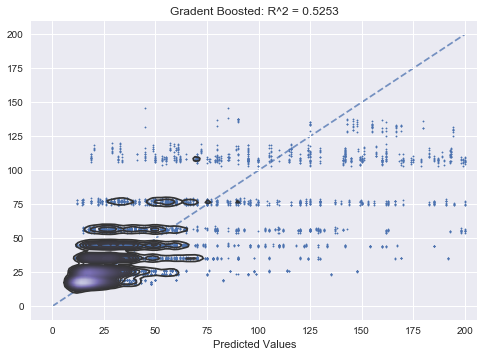

In [180]:
exp_array = np.asarray(LOF_expected)
pre_array = np.asarray(GBR_LOF_predicted)


plt.scatter(exp_array, pre_array, s=2)#, n_levels = 100, cmap='Purples_d', cbar=True); 
sns.kdeplot(exp_array, pre_array, n_levels = 100, cmap='Purples_d', cbar=True)
plt.title('Gradent Boosted: R^2 = {0:.4f}'.format(r2(LOF_expected, GBR_LOF_predicted)))
ax = plt.gca()
ax.set_xlim(0, 200, auto=True); ax.set_ylim(0, 200, auto=True)
ax.set_xlabel('Expected Values'); ax.set_xlabel('Predicted Values')
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), \
        np.max([ax.get_xlim(), ax.get_ylim()])]
plt.plot(lims, lims, '--', alpha=0.75, zorder=0)
plt.show()

In [181]:
import matplotlib.pyplot as plt
import pandas            as pds
import seaborn           as sns
import numpy             as np
import sklearn
import pickle

#Regression Modeling
from sklearn.linear_model    import Lasso as LSO, ElasticNet as ELN, Ridge as RDG
from sklearn.svm             import SVR
from sklearn.ensemble        import RandomForestRegressor as RFR, GradientBoostingRegressor as GBR
from sklearn.ensemble        import AdaBoostRegressor as ABR
#Testing
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics         import classification_report as cr, r2_score as r2
from sklearn.metrics         import accuracy_score as ac, mean_squared_error as mse
#Outlier Detection
from sklearn.neighbors       import LocalOutlierFactor as LOF
from sklearn.ensemble        import IsolationForest as ISF
from sklearn.covariance      import EllipticEnvelope as ELE
from sklearn.decomposition   import PCA


df = pds.read_csv('vivino_white_wine.csv', sep=",", header=0, encoding='ISO-8859-15')
df['rating']     = df['rating'].astype(float)
df['pricing']    = df['pricing'].str.replace('$', '')
df['pricing']    = df['pricing'].astype(float)
df['popularity'] = df['popularity'].astype(float)

Number of data entries in sliced database:  3291
Index(['wine', 'winery', 'region', 'country', 'rating', 'pricing',
       'popularity'],
      dtype='object') 




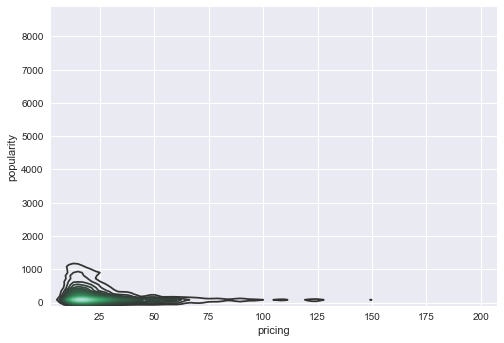

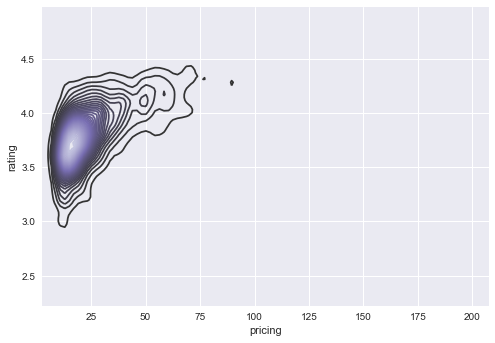

In [40]:
# print(df[(df['country'] == 'United States')].region.unique())

max_pricing = 200
min_popularity = 0
country = df.country.unique()
max_popularity = 10000

df_mod = df[(df['pricing'] < max_pricing) & (abs(df['popularity']) > min_popularity) & \
         (abs(df['popularity']) < max_popularity)] #& (df['country'] == country)]#(df['region'] == 'Napa Valley')]
df_mod.index = range(len(df_mod)); df_mod = df_mod.drop('Unnamed: 0', 1)
print('Number of data entries in sliced database: ', len(df_mod))
print(df_mod.columns,'\n\n')
sns.kdeplot(df_mod['pricing'], df_mod['popularity'], n_levels=50)
plt.show()

sns.kdeplot(df_mod['pricing'], df_mod['rating'], n_levels=50, cmap='Purples_d')
plt.show()

In [146]:
fh = ['rating', 'pricing']
LOF_list = LOF().fit_predict(df_mod[fh])
ISF_fit  = ISF().fit(df_mod[fh])
ISF_list = ISF_fit.predict(df_mod[fh])

LOF_outliers = []; ISF_outliers = []
for i in range(len(LOF_list)):
    if LOF_list[i] == -1:
        LOF_outliers.append(i)
    if ISF_list[i] == -1:
        ISF_outliers.append(i)

print('number of points cut by LOF outlier search: ', len(LOF_outliers))
print('number of points cut by ISF outlier search: ', len(ISF_outliers))

df_LOF       = df_mod.drop(df_mod.index[LOF_outliers])
df_LOF.index = range(len(df_LOF))
df_ISF       = df_mod.drop(df_mod.index[ISF_outliers])
df_ISF.index = range(len(df_ISF))

df_LOF_PCA               = pds.DataFrame(PCA().fit_transform(df_LOF[fh[1]].values.reshape(-1, 1)))
df_ISF_PCA               = pds.DataFrame(PCA().fit_transform(df_ISF[fh[1]].values.reshape(-1, 1)))
df_PCA                   = pds.DataFrame(PCA().fit_transform(df_mod[fh[1]].values.reshape(-1, 1)))
df_LOF_PCA['popularity'] = df_LOF['popularity']
df_ISF_PCA['popularity'] = df_ISF['popularity']
df_PCA['popularity']     = df_mod['popularity']

print('\n')
print('Number of empty cells in df_LOF_PCA: ', df_LOF_PCA.isnull().sum().sum())
print('Number of empty cells in df_ISF_PCA: ', df_ISF_PCA.isnull().sum().sum())
print('Number of empty cells in df_PCA    : ', df_PCA.isnull().sum().sum())
print('\n')
print('Total number of rows in df_LOF_PCA: ', len(df_LOF_PCA))
print('Total number of rows in df_ISF_PCA: ', len(df_ISF_PCA))
print('Total number of rows in df_PCA    : ', len(df_PCA))

number of points cut by LOF outlier search:  333
number of points cut by ISF outlier search:  333


Number of empty cells in df_LOF_PCA:  0
Number of empty cells in df_ISF_PCA:  0
Number of empty cells in df_PCA    :  0


Total number of rows in df_LOF_PCA:  2958
Total number of rows in df_ISF_PCA:  2958
Total number of rows in df_PCA    :  3291


## Raw Data Analysis

In [147]:
training_list = []; testing_list = []
for i in range(50):
    train, test = tts(df_mod, test_size=0.1)
    training_list.append(train)
    testing_list.append(test)
LSO_RAW_models = []; ELN_RAW_models = []; RDG_RAW_models = []; ABR_RAW_models = []
GBR_RAW_models = []; RFR_RAW_models = []; SVR_RAW_models = []
for training_set in training_list:
    model = LSO(); LSO_RAW_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))
    model = ELN(); ELN_RAW_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))
    model = RDG(); RDG_RAW_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]])) 
    model = GBR(); GBR_RAW_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]])) 
    model = RFR(); RFR_RAW_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))
    model = ABR(); ABR_RAW_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))
    model = SVR(kernel='rbf'); SVR_RAW_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                               training_set[fh[1]]))

In [148]:
LSO_RAW_predicted = []; ELN_RAW_predicted = []; RDG_RAW_predicted = []; GBR_RAW_predicted = [] 
RFR_RAW_predicted = []; SVR_RAW_predicted = []; ABR_RAW_predicted = []; RAW_expected = []
for i in range(len(testing_list)):
    LSO_RAW_predicted.extend(LSO_RAW_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    ELN_RAW_predicted.extend(ELN_RAW_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    RDG_RAW_predicted.extend(RDG_RAW_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    GBR_RAW_predicted.extend(GBR_RAW_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    RFR_RAW_predicted.extend(RFR_RAW_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    SVR_RAW_predicted.extend(SVR_RAW_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    ABR_RAW_predicted.extend(ABR_RAW_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    RAW_expected.extend(testing_list[i][fh[1]])

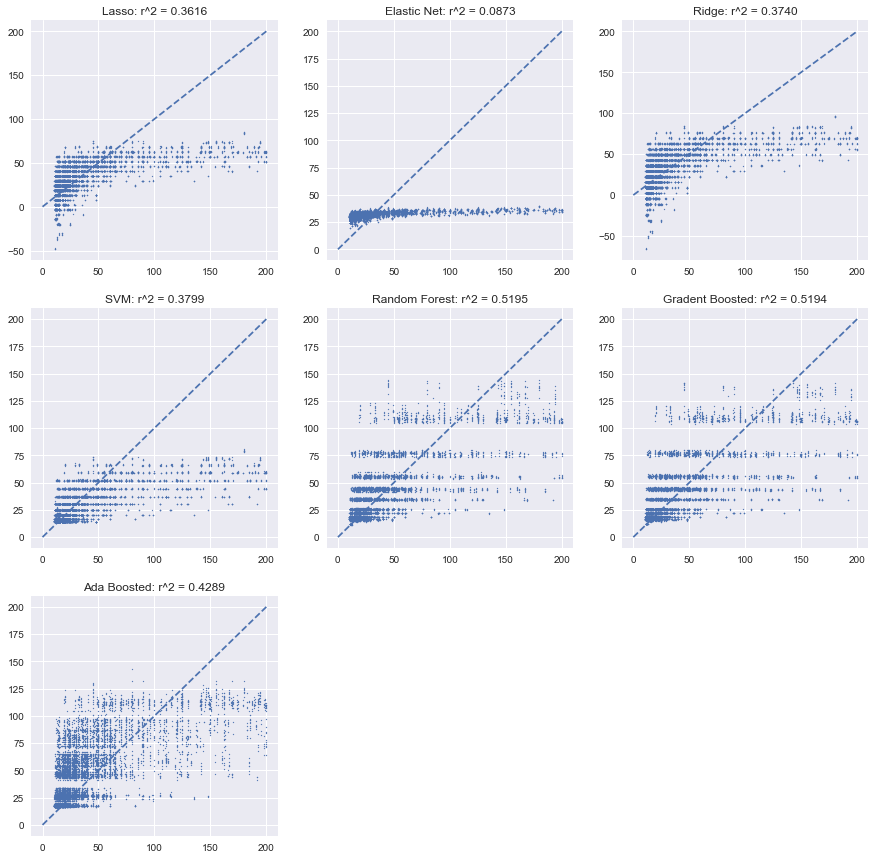

In [164]:
# print(RAW_expected, '\n\n', RDG_RAW_predicted)

plt.figure(1, figsize=(15, 15))
plt.subplot(3,3,1); plt.scatter(RAW_expected, LSO_RAW_predicted, s = 1) 
plt.title('Lasso: r^2 = {0:.4f}'.format(r2(RAW_expected, LSO_RAW_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,2); plt.scatter(RAW_expected, ELN_RAW_predicted, s = 1) 
plt.title('Elastic Net: r^2 = {0:.4f}'.format(r2(RAW_expected, ELN_RAW_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,3); plt.scatter(RAW_expected, RDG_RAW_predicted, s = 1); 
plt.title('Ridge: r^2 = {0:.4f}'.format(r2(RAW_expected, RDG_RAW_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,4); plt.scatter(RAW_expected, SVR_RAW_predicted, s = 1); 
plt.title('SVM: r^2 = {0:.4f}'.format(r2(RAW_expected, SVR_RAW_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,5); plt.scatter(RAW_expected, RFR_RAW_predicted, s = 1); 
plt.title('Random Forest: r^2 = {0:.4f}'.format(r2(RAW_expected, RFR_RAW_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,6); plt.scatter(RAW_expected, GBR_RAW_predicted, s = 1); 
plt.title('Gradent Boosted: r^2 = {0:.4f}'.format(r2(RAW_expected, GBR_RAW_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,7); plt.scatter(RAW_expected, ABR_RAW_predicted, s = 1); 
plt.title('Ada Boosted: r^2 = {0:.4f}'.format(r2(RAW_expected, ABR_RAW_predicted)))
plt.plot([0,200],[0,200],'--')
plt.show()

## LOF Trimmed Data Analysis

In [165]:
training_list = []; testing_list = []
for i in range(50):
    train, test = tts(df_LOF, test_size=0.1)
    training_list.append(train)
    testing_list.append(test)
LSO_LOF_models = []; ELN_LOF_models = []; RDG_LOF_models = []; ABR_LOF_models = []
GBR_LOF_models = []; RFR_LOF_models = []; SVR_LOF_models = []
for training_set in training_list:
    model = LSO(); LSO_LOF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))
    model = ELN(); ELN_LOF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))
    model = RDG(); RDG_LOF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]])) 
    model = GBR(); GBR_LOF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]])) 
    model = RFR(); RFR_LOF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))
    model = ABR(); ABR_LOF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))
    model = SVR(kernel='rbf'); SVR_LOF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                               training_set[fh[1]]))

In [166]:
LSO_LOF_predicted = []; ELN_LOF_predicted = []; RDG_LOF_predicted = []; GBR_LOF_predicted = [] 
RFR_LOF_predicted = []; SVR_LOF_predicted = []; ABR_LOF_predicted = []; LOF_expected = []
for i in range(len(testing_list)):
    LSO_LOF_predicted.extend(LSO_LOF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    ELN_LOF_predicted.extend(ELN_LOF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    RDG_LOF_predicted.extend(RDG_LOF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    GBR_LOF_predicted.extend(GBR_LOF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    RFR_LOF_predicted.extend(RFR_LOF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    SVR_LOF_predicted.extend(SVR_LOF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    ABR_LOF_predicted.extend(ABR_LOF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    LOF_expected.extend(testing_list[i][fh[1]])

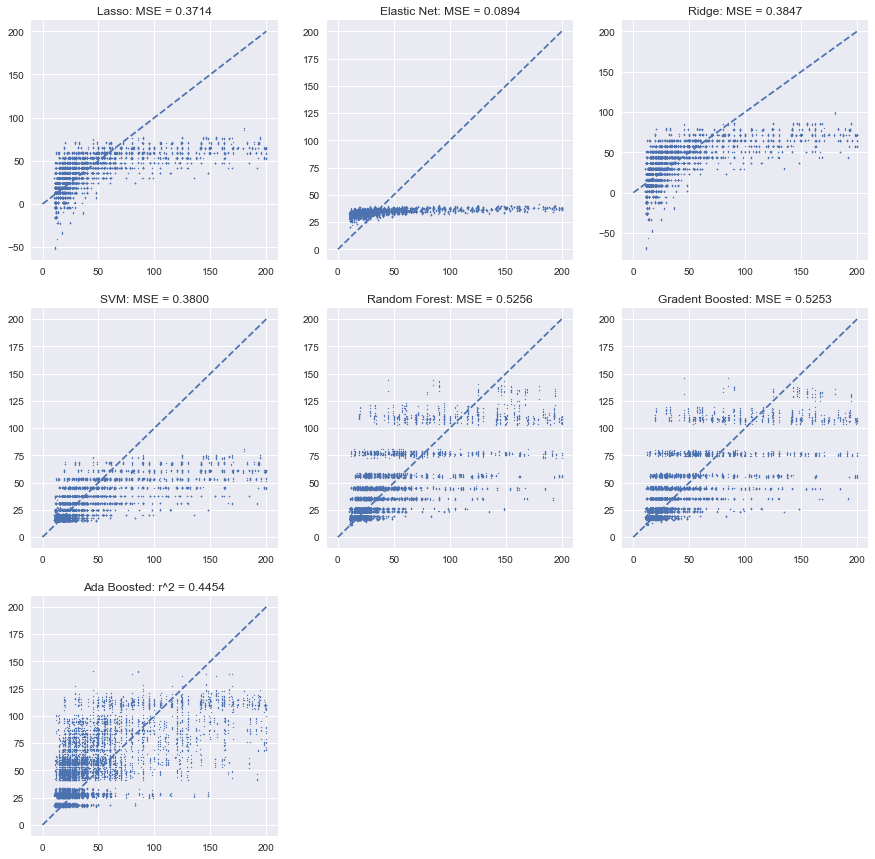

In [167]:
plt.figure(1, figsize=(15, 15))
plt.subplot(3,3,1); plt.scatter(LOF_expected, LSO_LOF_predicted, s=1) 
plt.title('Lasso: MSE = {0:.4f}'.format(r2(LOF_expected, LSO_LOF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,2); plt.scatter(LOF_expected, ELN_LOF_predicted, s=1) 
plt.title('Elastic Net: MSE = {0:.4f}'.format(r2(LOF_expected, ELN_LOF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,3); plt.scatter(LOF_expected, RDG_LOF_predicted, s=1); 
plt.title('Ridge: MSE = {0:.4f}'.format(r2(LOF_expected, RDG_LOF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,4); plt.scatter(LOF_expected, SVR_LOF_predicted, s=1); 
plt.title('SVM: MSE = {0:.4f}'.format(r2(LOF_expected, SVR_LOF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,5); plt.scatter(LOF_expected, RFR_LOF_predicted, s=1); 
plt.title('Random Forest: MSE = {0:.4f}'.format(r2(LOF_expected, RFR_LOF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,6); plt.scatter(LOF_expected, GBR_LOF_predicted, s=1); 
plt.title('Gradent Boosted: MSE = {0:.4f}'.format(r2(LOF_expected, GBR_LOF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,7); plt.scatter(LOF_expected, ABR_LOF_predicted, s=1); 
plt.title('Ada Boosted: r^2 = {0:.4f}'.format(r2(LOF_expected, ABR_LOF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.show()

## ISF Trimmed Data Analysis

In [168]:
training_list = []; testing_list = []
for i in range(50):
    train, test = tts(df_ISF, test_size=0.1)
    training_list.append(train)
    testing_list.append(test)
LSO_ISF_models = []; ELN_ISF_models = []; RDG_ISF_models = []; ABR_ISF_models = []
GBR_ISF_models = []; RFR_ISF_models = []; SVR_ISF_models = []
for training_set in training_list:
    model = LSO(); LSO_ISF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))
    model = ELN(); ELN_ISF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))
    model = RDG(); RDG_ISF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]])) 
    model = GBR(); GBR_ISF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]])) 
    model = RFR(); RFR_ISF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))
    model = ABR(); ABR_ISF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))
    model = SVR(kernel='rbf'); SVR_ISF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                               training_set[fh[1]]))

In [169]:
LSO_ISF_predicted = []; ELN_ISF_predicted = []; RDG_ISF_predicted = []; GBR_ISF_predicted = [] 
RFR_ISF_predicted = []; SVR_ISF_predicted = []; ABR_ISF_predicted = []; ISF_expected = []
for i in range(len(testing_list)):
    LSO_ISF_predicted.extend(LSO_ISF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    ELN_ISF_predicted.extend(ELN_ISF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    RDG_ISF_predicted.extend(RDG_ISF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    GBR_ISF_predicted.extend(GBR_ISF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    RFR_ISF_predicted.extend(RFR_ISF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    SVR_ISF_predicted.extend(SVR_ISF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    ABR_ISF_predicted.extend(ABR_ISF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    ISF_expected.extend(testing_list[i][fh[1]])

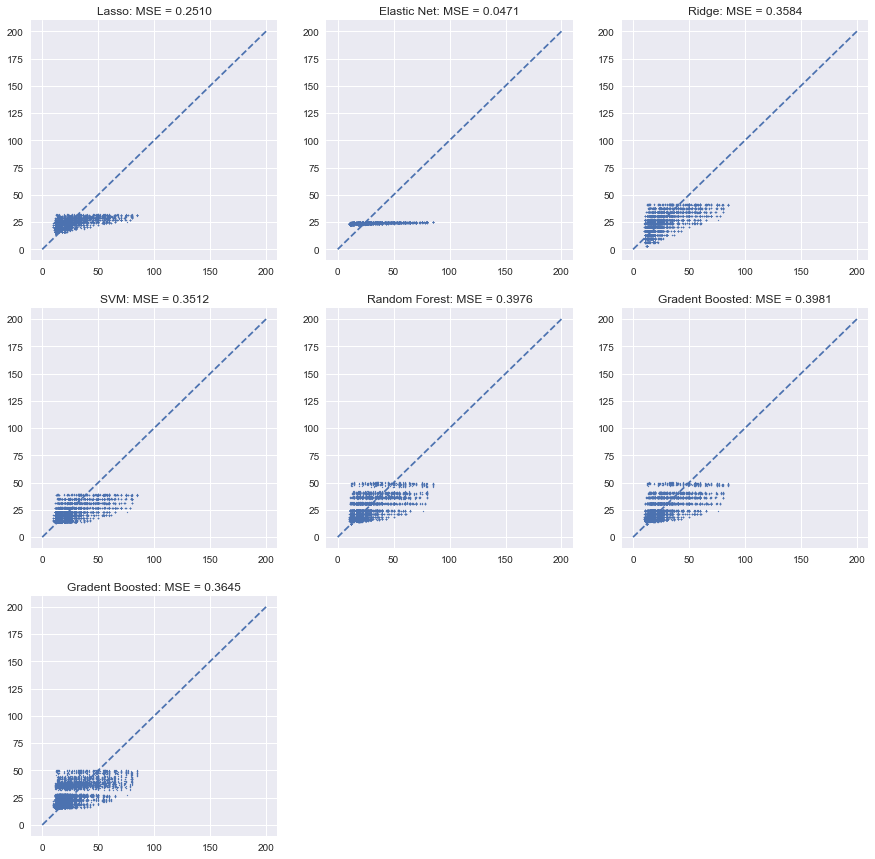

In [215]:
plt.figure(1, figsize=(15, 15))
plt.subplot(3,3,1); plt.scatter(ISF_expected, LSO_ISF_predicted, s=1)
plt.title('Lasso: MSE = {0:.4f}'.format(r2(ISF_expected, LSO_ISF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,2); plt.scatter(ISF_expected, ELN_ISF_predicted, s=1) 
plt.title('Elastic Net: MSE = {0:.4f}'.format(r2(ISF_expected, ELN_ISF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,3); plt.scatter(ISF_expected, RDG_ISF_predicted, s=1); 
plt.title('Ridge: MSE = {0:.4f}'.format(r2(ISF_expected, RDG_ISF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,4); plt.scatter(ISF_expected, SVR_ISF_predicted, s=1); 
plt.title('SVM: MSE = {0:.4f}'.format(r2(ISF_expected, SVR_ISF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,5); plt.scatter(ISF_expected, RFR_ISF_predicted, s=1); 
plt.title('Random Forest: MSE = {0:.4f}'.format(r2(ISF_expected, RFR_ISF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,6); plt.scatter(ISF_expected, GBR_ISF_predicted, s=1); 
plt.title('Gradent Boosted: MSE = {0:.4f}'.format(r2(ISF_expected, GBR_ISF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.subplot(3,3,7); plt.scatter(ISF_expected, ABR_ISF_predicted, s=1); 
plt.title('Gradent Boosted: MSE = {0:.4f}'.format(r2(ISF_expected, ABR_ISF_predicted)))
plt.plot([0,200],[0,200],'--')
plt.show()

# Picking the Model

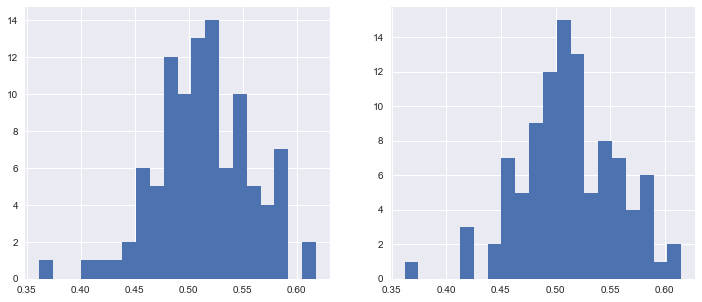

0.0443923340203
0.512278599074
53


In [213]:
training_list = []; testing_list = []
for i in range(100):
    train, test = tts(df_LOF, test_size=0.2)
    training_list.append(train)
    testing_list.append(test)
GBR_LOF_models = []; RFR_LOF_models = []
for training_set in training_list:
    model = GBR(); GBR_LOF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]])) 
    model = RFR(); RFR_LOF_models.append(model.fit(training_set[fh[0]].values.reshape(-1, 1), \
                                                   training_set[fh[1]]))


RFR_LOF_fit_list = []; GBR_LOF_fit_list = []
for i in range(len(testing_list)):
    list_x = list(testing_list[i][fh[1]])
    list_y = list(GBR_LOF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    GBR_LOF_fit_list.append(r2(list_x, list_y))
    list_y = list(RFR_LOF_models[i].predict(testing_list[i][fh[0]].values.reshape(-1, 1)))
    RFR_LOF_fit_list.append(r2(list_x, list_y))

plt.figure(1, figsize=(12, 5))
plt.subplot(1,2,1); plt.hist(GBR_LOF_fit_list, bins=20) 
# plt.title('Lasso: MSE = {0:.4f}'.format(r2(LOF_expected, LSO_LOF_predicted)))
plt.subplot(1,2,2); plt.hist(RFR_LOF_fit_list, bins=20) 
# plt.title('Elastic Net: MSE = {0:.4f}'.format(r2(LOF_expected, ELN_LOF_predicted)))
plt.show()

export_models = []
RFR_LOF_fit_array = np.asarray(RFR_LOF_fit_list)
RFR_LOF_fit_std   = np.std(RFR_LOF_fit_array)
RFR_LOF_fit_mean  = np.mean(RFR_LOF_fit_array)
for i in range(len(RFR_LOF_fit_array)):
    if abs(RFR_LOF_fit_array[i] - RFR_LOF_fit_mean) < RFR_LOF_fit_std/1.4142:
        export_models.append(RFR_LOF_models[i])
        
print(RFR_LOF_fit_std)
print(RFR_LOF_fit_mean)
print(len(export_models))
pickle.dump(export_models, open('Vivino_pricing.p', 'wb'))